# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.5.3


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
time: 359 µs (started: 2023-02-26 18:45:41 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.74 s (started: 2023-02-26 18:45:41 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'VGG19'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/regular_otsu/
versión Keras: 2.11.0
time: 1.75 ms (started: 2023-02-26 18:45:44 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 15.9 s (started: 2023-02-26 18:45:44 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    # Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG19(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for VGG19
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated

def create_custom_model(NUM_CLASSES, vgg_updated):

    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG,
               USE_DATA_AUG, DNN_NAME, FC_LAYER, ETL_DATASET):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE = 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model = Modelo de Deep Learning
        - TYPE_IMG = regular o inverted
        - USE_DATA_AUG = sin_DA o con_DA
        - DNN_NAME = Deep Neural Network Architecture's name
        - FC_LAYER: Number of Dense Layer. In this case is 4096
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_{ETL_DATASET.lower()}_imgs{SIZE}_' \
                + TYPE_IMG + f'_FC_{FC_LAYER}__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG + '/otsu_reg/' + MODEL_NAME

    # Por default lo guarda es en el mismo Google Colab's notebook
    custom_model.save(WEIGHTS_PATH)

    print(f'------ Model Saved in {WEIGHTS_PATH}')


time: 9.69 ms (started: 2023-02-26 18:46:00 +00:00)


# Imgs 64x64

- Test Accuracy: 0.879300594329834
- Test Loss: 0.7025412917137146
- time: 13min 22s
- F1 score: 0.8795214437651249
- Precision score: 0.8925298415571258
- Recall:  0.8793006204173717
- Epoch: 34/50





## Cargar la imágenes

In [8]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/regular_otsu/
time: 1.25 ms (started: 2023-02-26 18:46:07 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 4.84 s (started: 2023-02-26 18:46:08 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.51 ms (started: 2023-02-26 18:46:12 +00:00)


## Preparar el modelo

In [11]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

80134624/80134624 [==============================] - 0s 0us/step
time: 4.71 s (started: 2023-02-26 18:46:12 +00:00)


In [12]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 49 ms (started: 2023-02-26 18:46:17 +00:00)


In [13]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [14]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 32s 7ms/step - loss: 3.5831 - sparse_categorical_accuracy: 0.2656 - val_loss: 1.8119 - val_sparse_categorical_accuracy: 0.5376
Epoch 2/50
3325/3325 [==============================] - 23s 7ms/step - loss: 1.3696 - sparse_categorical_accuracy: 0.6359 - val_loss: 1.1686 - val_sparse_categorical_accuracy: 0.6877
Epoch 3/50
3325/3325 [==============================] - 23s 7ms/step - loss: 0.9290 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.8861 - val_sparse_categorical_accuracy: 0.7604
Epoch 4/50
3325/3325 [==============================] - 23s 7ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.7972 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7978
Epoch 5/50
3325/3325 [==============================] - 23s 7ms/step - loss: 0.5942 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.6817 - val_sparse_categorical_accuracy: 0.8127
Epoch 6/50
3325/3325 [==============================] - 23s 7ms/step - loss: 0.5076 -

In [15]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 666 ms (started: 2023-02-26 18:59:40 +00:00)


In [16]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 4ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.879300594329834
- Test Loss: 0.7025412917137146
- time: 
- F1 score: 0.8795214437651249
- Precision score: 0.8925298415571258
- Recall:  0.8793006204173717
- Epoch: 
*********************************************************************************************************************************
time: 4.98 s (started: 2023-02-26 18:59:40 +00:00)


## Graficando

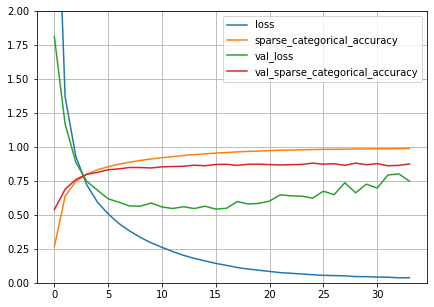

time: 234 ms (started: 2023-02-26 18:59:45 +00:00)


In [17]:
plot_loss(history)

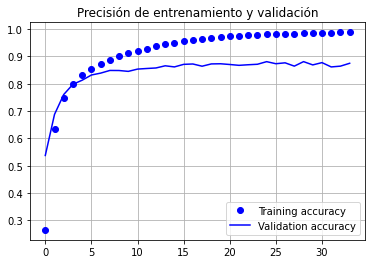

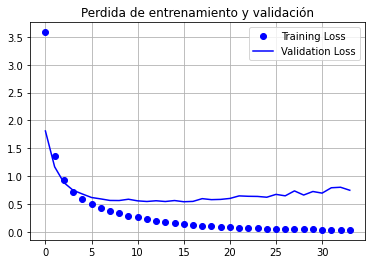

time: 274 ms (started: 2023-02-26 18:59:46 +00:00)


In [18]:
show_history(history)

In [19]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/otsu_reg/model_vgg19_etl_8g_imgs64_regular_FC_4096__OTSU.h5
time: 2.65 s (started: 2023-02-26 18:59:46 +00:00)


# Imgs 96x96

- Test Accuracy: 0.9109560251235962
- Test Loss: 0.4434407353401184
- time: 12min 38s
- F1 score: 0.912044906354876
- Precision score: 0.9251369672254655
- Recall:  0.9109560067681896
- Epoch: 25/50




## Cargar las imágenes

In [20]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_96/splits/regular_otsu/
time: 837 µs (started: 2023-02-26 18:59:49 +00:00)


In [21]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 5.06 s (started: 2023-02-26 18:59:49 +00:00)


In [22]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)

time: 1.43 ms (started: 2023-02-26 18:59:54 +00:00)


## Preparar el modelo

In [23]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 750 ms (started: 2023-02-26 18:59:54 +00:00)


In [24]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 39.9 ms (started: 2023-02-26 18:59:54 +00:00)


In [25]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

## Entrenar modelo

In [26]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 32s 9ms/step - loss: 2.7923 - sparse_categorical_accuracy: 0.4130 - val_loss: 0.9729 - val_sparse_categorical_accuracy: 0.7380
Epoch 2/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.7319 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.8181
Epoch 3/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.4877 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.5081 - val_sparse_categorical_accuracy: 0.8548
Epoch 4/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4375 - val_sparse_categorical_accuracy: 0.8759
Epoch 5/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.2976 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.4109 - val_sparse_categorical_accuracy: 0.8818
Epoch 6/50
3325/3325 [==============================] - 30s 9ms/step - loss: 0.2438 -

In [27]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 875 ms (started: 2023-02-26 19:12:33 +00:00)


In [28]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 2s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.9109560251235962
- Test Loss: 0.4434407353401184
- time: 
- F1 score: 0.912044906354876
- Precision score: 0.9251369672254655
- Recall:  0.9109560067681896
- Epoch: 
*********************************************************************************************************************************
time: 6.19 s (started: 2023-02-26 19:12:34 +00:00)


## Graficando

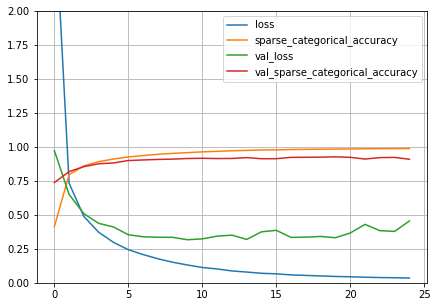

time: 382 ms (started: 2023-02-26 19:12:40 +00:00)


In [29]:
plot_loss(history)

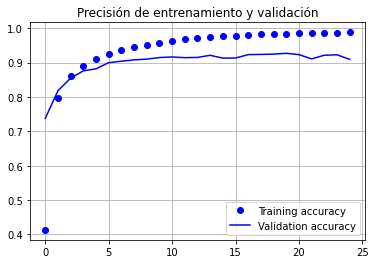

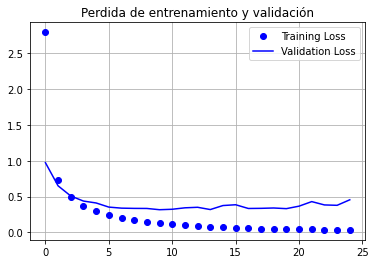

time: 253 ms (started: 2023-02-26 19:12:40 +00:00)


In [30]:
show_history(history)

In [31]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/otsu_reg/model_vgg19_etl_8g_imgs96_regular_FC_4096__OTSU.h5
time: 1.24 s (started: 2023-02-26 19:12:41 +00:00)


# Imgs 112x112

- Test Accuracy: 0.9323180913925171
- Test Loss: 0.41091203689575195
- time: 19min 5s
- F1 score: 0.9324958827437123
- Precision score: 0.9400910799138229
- Recall:  0.9323181049069373
- Epoch: 34/50


## Cargar imágenes

In [32]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_112/splits/regular_otsu/
time: 663 µs (started: 2023-02-26 19:12:42 +00:00)


In [33]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 6.19 s (started: 2023-02-26 19:12:42 +00:00)


In [34]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 978 µs (started: 2023-02-26 19:12:48 +00:00)


## Preparar el modelo

In [35]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 691 ms (started: 2023-02-26 19:12:48 +00:00)


In [36]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 34 ms (started: 2023-02-26 19:12:49 +00:00)


In [37]:
print(custom_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

## Entrenar modelo


In [38]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 35s 10ms/step - loss: 2.3188 - sparse_categorical_accuracy: 0.5086 - val_loss: 0.7934 - val_sparse_categorical_accuracy: 0.7806
Epoch 2/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.5513 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.5081 - val_sparse_categorical_accuracy: 0.8581
Epoch 3/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.3633 - sparse_categorical_accuracy: 0.8937 - val_loss: 0.3819 - val_sparse_categorical_accuracy: 0.8920
Epoch 4/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.2740 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.3859 - val_sparse_categorical_accuracy: 0.8905
Epoch 5/50
3325/3325 [==============================] - 33s 10ms/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.3366 - val_sparse_categorical_accuracy: 0.9068
Epoch 6/50
3325/3325 [==============================] - 34s 10ms/step - loss: 0.

## Graficando

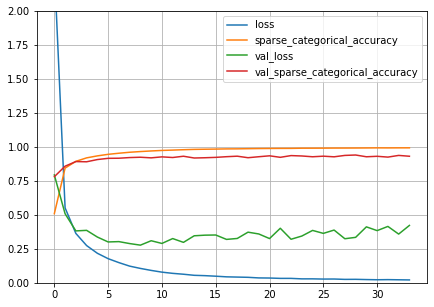

time: 156 ms (started: 2023-02-26 19:31:54 +00:00)


In [39]:
plot_loss(history)

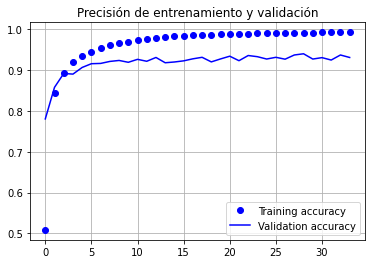

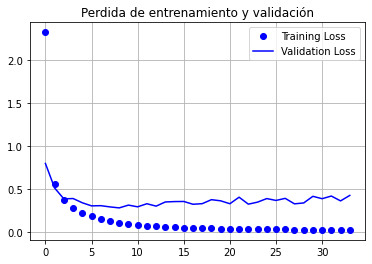

time: 254 ms (started: 2023-02-26 19:31:55 +00:00)


In [40]:
show_history(history)

In [41]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/otsu_reg/model_vgg19_etl_8g_imgs112_regular_FC_4096__OTSU.h5
time: 1.24 s (started: 2023-02-26 19:31:55 +00:00)


## Métricas

In [42]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 927 ms (started: 2023-02-26 19:31:56 +00:00)


In [43]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 3s 6ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.9323180913925171
- Test Loss: 0.41091203689575195
- time: 
- F1 score: 0.9324958827437123
- Precision score: 0.9400910799138229
- Recall:  0.9323181049069373
- Epoch: 
*********************************************************************************************************************************
time: 7.11 s (started: 2023-02-26 19:31:57 +00:00)


# Imgs 127x127

- Test Accuracy: 0.9328116178512573
- Test Loss: 0.3308980464935303
- time: 16min 48s
- F1 score: 0.9330827232896071
- Precision score: 0.9419283170970304
- Recall:  0.9328116187253243
- Epoch: 25/50




## Cargar imágenes

In [44]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_127/splits/regular_otsu/
time: 635 µs (started: 2023-02-26 19:32:04 +00:00)


In [45]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 8.4 s (started: 2023-02-26 19:32:04 +00:00)


In [46]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.39 ms (started: 2023-02-26 19:32:13 +00:00)


## Preparar el modelo

In [47]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 740 ms (started: 2023-02-26 19:32:13 +00:00)


In [48]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 33.6 ms (started: 2023-02-26 19:32:13 +00:00)


In [49]:
print(custom_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0   

## Entrenar modelo

In [50]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 43s 13ms/step - loss: 2.2228 - sparse_categorical_accuracy: 0.5259 - val_loss: 0.7287 - val_sparse_categorical_accuracy: 0.7959
Epoch 2/50
3325/3325 [==============================] - 41s 12ms/step - loss: 0.5021 - sparse_categorical_accuracy: 0.8565 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8671
Epoch 3/50
3325/3325 [==============================] - 40s 12ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.9046 - val_loss: 0.3281 - val_sparse_categorical_accuracy: 0.9061
Epoch 4/50
3325/3325 [==============================] - 41s 12ms/step - loss: 0.2405 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.3092 - val_sparse_categorical_accuracy: 0.9098
Epoch 5/50
3325/3325 [==============================] - 40s 12ms/step - loss: 0.1890 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.3080 - val_sparse_categorical_accuracy: 0.9118
Epoch 6/50
3325/3325 [==============================] - 40s 12ms/step - loss: 0.

## Graficando

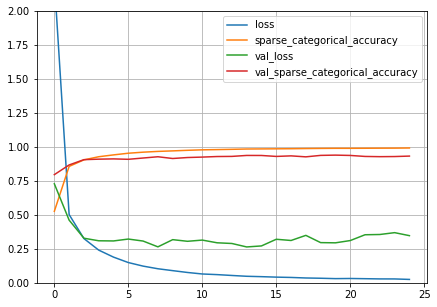

time: 166 ms (started: 2023-02-26 19:49:02 +00:00)


In [51]:
plot_loss(history)

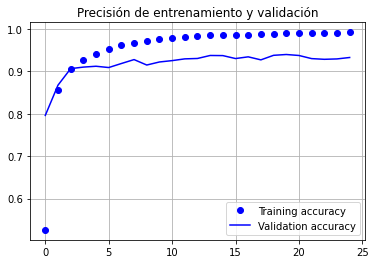

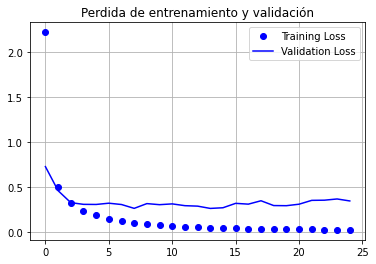

time: 240 ms (started: 2023-02-26 19:49:02 +00:00)


In [52]:
show_history(history)

In [53]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER, ETL_DATASET)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG19/weights_vgg19/sin_DA/regular/otsu_reg/model_vgg19_etl_8g_imgs127_regular_FC_4096__OTSU.h5
time: 1.22 s (started: 2023-02-26 19:49:02 +00:00)


## Métricas


In [54]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.04 s (started: 2023-02-26 19:49:04 +00:00)


In [55]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 4s 8ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.9328116178512573
- Test Loss: 0.3308980464935303
- time: 
- F1 score: 0.9330827232896071
- Precision score: 0.9419283170970304
- Recall:  0.9328116187253243
- Epoch: 
*********************************************************************************************************************************
time: 8.41 s (started: 2023-02-26 19:49:05 +00:00)


In [56]:
runtime.unassign()

time: 283 ms (started: 2023-02-26 19:49:13 +00:00)
